In [5]:
#Cargas e importacion de articulos para obtener nombre y referencias de SKUs
# 📦 Importar librerías
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 Ruta base
ruta_base = Path("../data/raw")

# 📄 Cargar artículos
articulos = pd.read_excel(ruta_base / "articulos.xlsx")

# 📄 Cargar clientes
clientes = pd.read_excel(ruta_base / "clientes.xlsx")

# 📄 Cargar todas las ventas itemizadas
archivos_ventas_items = sorted(ruta_base.glob("ventas_dcto_items_20*.xlsx"))
ventas_items = pd.concat([pd.read_excel(f, engine="openpyxl") for f in archivos_ventas_items], ignore_index=True)

# ✅ Confirmaciones
print("✅ Artículos:", articulos.shape)
print("✅ Clientes:", clientes.shape)
print("✅ Ventas Items:", ventas_items.shape)


✅ Artículos: (5098, 13)
✅ Clientes: (7909, 17)
✅ Ventas Items: (631714, 22)


In [12]:
# Paso 0: importar librerías y cargar datos
import pandas as pd

# Cargar el archivo si no lo has hecho antes (ajusta la ruta si es necesario)
ventas_items = pd.read_excel("../data/raw/ventas_dcto_items_2025.xlsx", engine="openpyxl")

# Paso 1: convertir fechas y asignar mes
ventas_items['fecha'] = pd.to_datetime(ventas_items['defecha'])
ventas_items['mes'] = ventas_items['fecha'].dt.to_period('M')

# Paso 2: agregar venta total por SKU por mes
sku_mensual = ventas_items.groupby(['cod_articulo_servicio', 'mes']).agg({
    'cantidad': 'sum'
}).reset_index()

# Paso 3: calcular el promedio mensual por SKU (general, no por cliente)
promedio_mensual = sku_mensual.groupby('cod_articulo_servicio')['cantidad'].mean().reset_index()
promedio_mensual.rename(columns={'cantidad': 'promedio_mensual_unidades'}, inplace=True)

# Vista previa
print(promedio_mensual.head())


  cod_articulo_servicio  promedio_mensual_unidades
0                   .30                       1.00
1                  .202                      20.50
2                  .302                      20.75
3                 12029                       3.00
4                .COPEO                     478.25


In [23]:
## Paso 4: Calcular el promedio anual estimado como proyección del promedio mensual
#El codigo a continuacion garantiza la consistencia en la relaion logica entre mensual y anual 
#Se evitan los errores asociados con tener promedios mensuales y anuales inconsistentes.

sku_metrics = promedio_mensual.copy()
sku_metrics['promedio_anual_unidades'] = sku_metrics['promedio_mensual_unidades'] * 12


In [18]:
# Asegúrate de que los nombres sean únicos antes de hacer el merge
promedio_mensual.rename(columns={'cantidad': 'promedio_mensual_unidades'}, inplace=True)
promedio_anual.rename(columns={'cantidad': 'promedio_anual_unidades'}, inplace=True)


In [22]:
# Renombrar antes del merge para evitar sufijos _x y _y
promedio_mensual.rename(columns={'cantidad': 'promedio_mensual_unidades'}, inplace=True)
promedio_anual.rename(columns={'cantidad': 'promedio_anual_unidades'}, inplace=True)

# Hacer merge limpio sin duplicados
sku_metrics = pd.merge(promedio_mensual, promedio_anual, on='cod_articulo_servicio', how='outer')
print(sku_metrics.columns)




Index(['cod_articulo_servicio', 'promedio_mensual_unidades_x',
       'promedio_mensual_unidades_y', 'promedio_anual_unidades'],
      dtype='object')


In [24]:
# KMeans clustering (si quieres clasificar en categorías)
from sklearn.cluster import KMeans
import numpy as np

# 1. Asegúrate de que la columna existe y no hay valores nulos ni negativos
X = sku_metrics[['promedio_mensual_unidades']].dropna()
X = X[X['promedio_mensual_unidades'] > 0].copy()

# 2. KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
X['cluster'] = kmeans.fit_predict(X[['promedio_mensual_unidades']])

# 3. Asignar etiquetas de rotación
centroides = kmeans.cluster_centers_.flatten()
orden = np.argsort(centroides)
mapeo = {orden[0]: 'bajo', orden[1]: 'medio', orden[2]: 'alto'}
X['categoria_rotacion'] = X['cluster'].map(mapeo)

# 4. Merge de vuelta a sku_metrics
sku_metrics = sku_metrics.merge(X[['promedio_mensual_unidades', 'categoria_rotacion']],
                                on='promedio_mensual_unidades', how='left')



In [25]:
#Definicion del umbral de sobrestock asociado 
sku_metrics['umbral_sobrestock'] = sku_metrics['promedio_mensual_unidades'] * 1.5



In [26]:
# Asegúrate de que la fecha esté en formato datetime
ventas_items['fecha'] = pd.to_datetime(ventas_items['defecha'])

# Obtener la última compra por SKU de forma confiable
ultima_compra = ventas_items.sort_values('fecha').groupby('cod_articulo_servicio').last().reset_index()
ultima_compra = ultima_compra[['cod_articulo_servicio', 'cantidad']].rename(columns={
    'cantidad': 'cantidad_ultima_compra'
})

#Extraer el merge asociado
sku_metrics = sku_metrics.merge(ultima_compra, on='cod_articulo_servicio', how='left')




In [27]:
#Evaluacion de la seccion de sobrestok asociado 
sku_metrics['posible_sobrestock'] = sku_metrics['cantidad_ultima_compra'] > sku_metrics['umbral_sobrestock']


In [ ]:
#Formulas asociadas a los calculos del sobrestock mensual y el sobrestock anual 
#La formula calcula ambos umbrales por separado (mensual y anual) y luego saca un promedio entre ellos para la suavizacion de desviaciones
sku_metrics['umbral_sobrestock_mensual'] = sku_metrics['promedio_mensual_unidades'] * 1.5
sku_metrics['umbral_sobrestock_anual'] = sku_metrics['promedio_anual_unidades'] / 12 * 1.5

# Promedio ponderado o simple (aquí usamos simple)
sku_metrics['umbral_sobrestock'] = (
    sku_metrics['umbral_sobrestock_mensual'] + sku_metrics['umbral_sobrestock_anual']
) / 2


In [31]:
#Inspeccion de las columnas del Dataframe Articulos
print(articulos.columns)

Index(['codigo', 'barras', 'nombre', 'unidad', 'iva', 'activo', 'referencia',
       'kit', 'volumen', 'peso', 'codbscula', 'reginvima', 'xunidad'],
      dtype='object')


In [32]:
#Agregar el nombre del articulo asociado a la referencia del SKU
#Se utiliza el dataframe de articulos con el objetivo de contener los datos 
# Merge para agregar el nombre del artículo a sku_metrics
sku_metrics = sku_metrics.merge(
    articulos[['codigo', 'nombre']],
    left_on='cod_articulo_servicio',
    right_on='codigo',
    how='left'
)

# Renombrar la columna 'nombre' para mayor claridad
sku_metrics.rename(columns={'nombre': 'nombre_producto'}, inplace=True)

# Eliminar la columna 'codigo' duplicada si ya no se necesita
sku_metrics.drop(columns=['codigo'], inplace=True)


In [34]:
# Añadir nombre del producto al conjunto de columnas exportables
columnas_exportar = [
    'cod_articulo_servicio',
    'nombre_producto',
    'promedio_mensual_unidades',
    'promedio_anual_unidades',
    'umbral_sobrestock',
    'cantidad_ultima_compra',
    'posible_sobrestock'
]


# Exportar archivo
sku_metrics[columnas_exportar].to_excel('alertas_sobrestock.xlsx', index=False)


In [10]:
sku_metrics = sku_metrics.merge(ultima_compra, on='cod_articulo_servicio', how='left')


In [11]:
sku_metrics['posible_sobrestock'] = sku_metrics['cantidad_ultima_compra'] > sku_metrics['umbral_sobrestock']


In [12]:
print(sku_metrics[['cod_articulo_servicio', 'promedio_mensual_unidades', 'umbral_sobrestock', 'cantidad_ultima_compra', 'posible_sobrestock']].head(100))


   cod_articulo_servicio  promedio_mensual_unidades  umbral_sobrestock  \
0                    .30                        1.0                1.5   
1                    .30                        1.0                1.5   
2                    .30                        1.0                1.5   
3                    .30                        1.0                1.5   
4                    .30                        1.0                1.5   
..                   ...                        ...                ...   
95                   .30                        1.0                1.5   
96                   .30                        1.0                1.5   
97                   .30                        1.0                1.5   
98                   .30                        1.0                1.5   
99                   .30                        1.0                1.5   

    cantidad_ultima_compra  posible_sobrestock  
0                      1.0               False  
1            

In [13]:
articulos = pd.read_excel("../data/raw/articulos.xlsx", engine="openpyxl")


In [14]:
#Verificacion del nombre del producto 
print(articulos.columns)


Index(['codigo', 'barras', 'nombre', 'unidad', 'iva', 'activo', 'referencia',
       'kit', 'volumen', 'peso', 'codbscula', 'reginvima', 'xunidad'],
      dtype='object')


In [15]:
#Realizar un merge para incluir en el analisis de las columnas asociadas
# Realizar merge usando cod_articulo_servicio y codigo
sku_metrics = sku_metrics.merge(
    articulos[['codigo', 'nombre']],
    left_on='cod_articulo_servicio',
    right_on='codigo',
    how='left'
)

# Renombrar la columna para claridad
sku_metrics.rename(columns={'nombre': 'nombre_producto'}, inplace=True)

# Eliminar la columna 'codigo' duplicada si ya no se necesita
sku_metrics.drop(columns=['codigo'], inplace=True)


In [16]:
# Identificar productos con nombres duplicados
sku_por_nombre = articulos.groupby('nombre')['codigo'].nunique().reset_index()
nombres_duplicados = sku_por_nombre[sku_por_nombre['codigo'] > 1]['nombre']

# Marcar los que tienen nombre duplicado
articulos['nombre_duplicado'] = articulos['nombre'].isin(nombres_duplicados)

# Agregar al dataset final
sku_metrics = sku_metrics.merge(
    articulos[['codigo', 'nombre', 'nombre_duplicado']],
    left_on='cod_articulo_servicio',
    right_on='codigo',
    how='left'
)
sku_metrics.rename(columns={'nombre': 'nombre_producto'}, inplace=True)


In [17]:
# Definir columnas clave para exportar
columnas_exportar = [
    'cod_articulo_servicio',
    'nombre_producto',
    'promedio_mensual_unidades',
    'umbral_sobrestock',
    'cantidad_ultima_compra',
    'posible_sobrestock',
    'nombre_duplicado'
]

# Exportar archivo
sku_metrics[columnas_exportar].to_excel(
    '../outputs/alertas_sobrestock_sku.xlsx',
    index=False
)


In [18]:
# Exportar la tabla de métricas SKU con umbrales y sobrestock
sku_metrics.to_excel("../outputs/sku_sobrestock_analisis.xlsx", index=False)



In [19]:
# Verificar cuántos SKUs tienen el mismo nombre
sku_duplicados = articulos.groupby('nombre')['codigo'].nunique().reset_index()
sku_duplicados = sku_duplicados[sku_duplicados['codigo'] > 1]


In [20]:
import pandas as pd

# Paso 1: convertir la columna de fecha
ventas_items['fecha'] = pd.to_datetime(ventas_items['defecha'])

# ✅ Filtrar solo los años 2024 y 2025
ventas_items = ventas_items[ventas_items['fecha'].dt.year.isin([2024, 2025])]

# Asignar mes
ventas_items['mes'] = ventas_items['fecha'].dt.to_period('M')

# Agrupación: SKU x mes
sku_mensual = ventas_items.groupby(['cod_articulo_servicio', 'mes']).agg({
    'cantidad': 'sum'
}).reset_index()

# Calcular promedio mensual por SKU
promedio_mensual = sku_mensual.groupby('cod_articulo_servicio')['cantidad'].mean().reset_index()
promedio_mensual.rename(columns={'cantidad': 'promedio_mensual_unidades'}, inplace=True)


In [21]:
ventas_items['año'] = ventas_items['fecha'].dt.year

ventas_anual = ventas_items.groupby(['cod_articulo_servicio', 'año'])['cantidad'].sum().reset_index()
promedio_anual = ventas_anual.groupby('cod_articulo_servicio')['cantidad'].mean().reset_index()
promedio_anual.rename(columns={'cantidad': 'promedio_anual_unidades'}, inplace=True)


In [22]:
sku_metrics = promedio_mensual.merge(promedio_anual, on='cod_articulo_servicio', how='outer')


In [23]:
sku_metrics['umbral_sobrestock'] = sku_metrics['promedio_mensual_unidades'] * 1.5


In [24]:
ultima_compra = ventas_items.sort_values('fecha').groupby('cod_articulo_servicio').tail(1)
ultima_compra = ultima_compra[['cod_articulo_servicio', 'cantidad']].rename(columns={'cantidad': 'cantidad_ultima_compra'})


In [25]:
sku_metrics = sku_metrics.merge(ultima_compra, on='cod_articulo_servicio', how='left')
sku_metrics['posible_sobrestock'] = sku_metrics['cantidad_ultima_compra'] > sku_metrics['umbral_sobrestock']


In [26]:
# --- Enriquecer con nombre del producto y duplicados ---

# Marcar nombres de productos duplicados (mismo nombre, diferentes códigos)
sku_por_nombre = articulos.groupby('nombre')['codigo'].nunique().reset_index()
nombres_duplicados = sku_por_nombre[sku_por_nombre['codigo'] > 1]['nombre']
articulos['nombre_duplicado'] = articulos['nombre'].isin(nombres_duplicados)

# Agregar nombre y marca de duplicado al dataset principal
sku_metrics = sku_metrics.merge(
    articulos[['codigo', 'nombre', 'nombre_duplicado']],
    left_on='cod_articulo_servicio',
    right_on='codigo',
    how='left'
)
sku_metrics.rename(columns={'nombre': 'nombre_producto'}, inplace=True)
sku_metrics.drop(columns=['codigo'], inplace=True)


In [27]:
# Selección de columnas para exportar
columnas_exportar = [
    'cod_articulo_servicio',
    'nombre_producto',
    'promedio_mensual_unidades',
    'promedio_anual_unidades',
    'umbral_sobrestock',
    'cantidad_ultima_compra',
    'posible_sobrestock',
    'nombre_duplicado'
]

# Exportar a archivo
sku_metrics[columnas_exportar].to_excel("alertas_sobrestock_2024_2025.xlsx", index=False)


In [30]:
sku_metrics['punto_reorden'] = sku_metrics['promedio_mensual_unidades'] * 0.5


In [31]:
sku_metrics['posible_faltante'] = sku_metrics['cantidad_ultima_compra'] < sku_metrics['punto_reorden']


In [32]:
columnas_exportar_faltantes = [
    'cod_articulo_servicio',
    'nombre_producto',
    'promedio_mensual_unidades',
    'promedio_anual_unidades',
    'punto_reorden',
    'cantidad_ultima_compra',
    'posible_faltante',
    'nombre_duplicado'
]


In [33]:
sku_metrics[columnas_exportar_faltantes].to_excel("alertas_faltantes_2024_2025.xlsx", index=False)


In [5]:
# 🔗 Unir ventas_items con artículos para traer información del SKU
ventas_items = ventas_items.merge(articulos, left_on='cod_articulo_servicio', right_on='codigo', how='left')

# 🔗 Unir ventas_items con clientes para identificar clientes corporativos
ventas_items = ventas_items.merge(clientes, left_on='cod_cliente', right_on='codigo', how='left')

# Confirmación de unión
print("✅ Dataset combinado:", ventas_items.shape)


✅ Dataset combinado: (631715, 52)


In [7]:
#identificar las primeras variables asociadsa al sobrestock
# 🧩 Unir ventas_items con clientes para identificar clientes corporativos
ventas_items = ventas_items.merge(
    clientes,
    left_on='cod_cliente',
    right_on='codigo',
    how='left',
    suffixes=('', '_cliente')  # Evita el conflicto de columnas duplicadas
)


In [8]:
#Verificacion de los SKUs Unicos y las ventas totales
# 🎯 SKU únicos y ventas totales por referencia
sku_ventas = ventas_items.groupby('cod_articulo_servicio').agg({
    'nombre_articulo_servicio': 'first',
    'cantidad': 'sum',
    'subtotal': 'sum',
    'costo': 'sum'
}).reset_index()

# Crear columna de margen bruto estimado
sku_ventas['margen_estimado'] = sku_ventas['subtotal'] - sku_ventas['costo']

# Mostrar los más vendidos
sku_ventas.sort_values(by='cantidad', ascending=False).head(10)


,cod_articulo_servicio,nombre_articulo_servicio,cantidad,subtotal,costo,margen_estimado
666,101039,MERMEL 4 FRUTAS ST DALF X 284 GR,173026.0,2.835482e+09,1.384077e+09,1.451405e+09
673,101055,MERMEL FRESA ST DALF X 284 GR,152796.0,2.508191e+09,1.223989e+09,1.284201e+09
670,101052,MERMEL GROSELLA ST DALF X 284 GR,78277.0,1.280275e+09,6.366947e+08,6.435805e+08
674,101056,MERMEL FRAMBUESA ST DALF X 284 GR,60419.0,9.882228e+08,5.007381e+08,4.874847e+08
2700,159005,MINI BABYBEL X 6 X 120G,52178.0,7.642687e+08,3.361435e+08,4.281252e+08
696,101096,MERMEL MINI CAJA X 4 UNID X 28 GR,47698.0,6.504211e+08,3.420051e+08,3.084160e+08
675,101057,MERMEL NARANJA ST DALF X 284 GR,47012.0,7.626429e+08,3.753511e+08,3.872917e+08
2645,150174,ILE DE FRANCE BRIE X 125 GR,44325.0,7.860036e+08,4.630564e+08,3.229472e+08
679,101062,MERMEL DURAZNO ST DALF X 284 GR,42976.0,7.033456e+08,3.431025e+08,3.602431e+08
671,101053,MERMEL AR¡NDANOS ( MORA SALVAJE ST DALF X 284...,40974.0,6.633389e+08,3.285286e+08,3.348104e+08


In [18]:
total_skus_ofertados = articulos['codigo'].nunique()
print(f"🔢 Total de SKUs ofertados: {total_skus_ofertados}")


🔢 Total de SKUs ofertados: 5095


In [19]:
#Identificacion de los SKUs sin ventas historicas
skus_sin_ventas = set(articulos['codigo']) - set(ventas_items['cod_articulo_servicio'])
print(f"🕳️ SKUs sin ventas históricas: {len(skus_sin_ventas)}")


🕳️ SKUs sin ventas históricas: 2682


In [20]:
#Dataframe que detalle estos productos
skus_sin_ventas_df = articulos[articulos['codigo'].isin(skus_sin_ventas)]
skus_sin_ventas_df.head()


,codigo,barras,nombre,unidad,iva,activo,referencia,kit,volumen,peso,codbscula,reginvima,xunidad
0,130220,8851081200245,SALSA CHILE BEST CHOICE X 880 GRS,UNIDAD,19,S,NaN,False,20,0.0,NaN,NaN,True
3,150701,8410226017645,ACEITUNA NEGRA SIN HUESOxUn,UNIDAD,19,N,NaN,False,20,0.0,NaN,NaN,True
4,150705,8410226069064,ACEITUNA PICARDIASxUn,UNIDAD,19,N,NaN,False,20,0.0,NaN,NaN,True
5,150702,7708687881754,CB. GRAGEAS UVAS CHOCO BLANCO S/A 100,UNIDAD,19,N,NaN,False,20,0.0,NaN,NaN,True
6,108032,7708227055485,AGUA SIN GAS X 3000 ML,UNIDAD,0,N,529178,False,20,0.0,NaN,NaN,True


In [22]:
print(f"Total de SKUs sin ventas detallados: {skus_sin_ventas_df.shape[0]}")


Total de SKUs sin ventas detallados: 2684


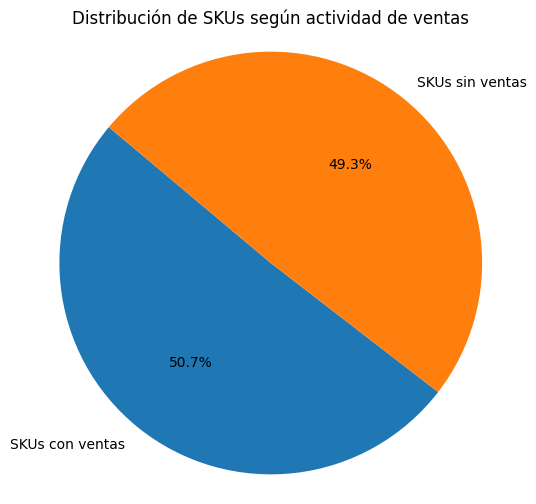

In [21]:
#Comparacion de SKUs con ventas y SKUs sin ventas
import matplotlib.pyplot as plt

labels = ['SKUs con ventas', 'SKUs sin ventas']
sizes = [ventas_items['cod_articulo_servicio'].nunique(), len(skus_sin_ventas)]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de SKUs según actividad de ventas')
plt.axis('equal')
plt.show()


In [9]:
#Analizar Ventas de SKU y su determinada frecuencia
# 📆 Días únicos con ventas por SKU
ventas_items['fecha'] = pd.to_datetime(ventas_items['defecha'], errors='coerce')
dias_sku = ventas_items.groupby('cod_articulo_servicio')['fecha'].nunique().reset_index()
dias_sku.columns = ['cod_articulo_servicio', 'dias_con_ventas']

# Unir al resumen anterior
sku_ventas = sku_ventas.merge(dias_sku, on='cod_articulo_servicio', how='left')


In [10]:
#Relacion con clientes, absorción por SKU
# 🧑‍🤝‍🧑 Clientes únicos por SKU
clientes_sku = ventas_items.groupby('cod_articulo_servicio')['cod_cliente'].nunique().reset_index()
clientes_sku.columns = ['cod_articulo_servicio', 'clientes_unicos']

# Añadir al resumen
sku_ventas = sku_ventas.merge(clientes_sku, on='cod_articulo_servicio', how='left')


In [11]:
#Calculo del promedio de dias por SKU
sku_ventas['promedio_venta_diaria'] = sku_ventas['cantidad'] / sku_ventas['dias_con_ventas']


In [12]:
#Identificacion de posibles criterios con sobrestock
# Posibles sospechosos de sobrestock
sospechosos_sobrestock = sku_ventas[
    (sku_ventas['cantidad'] > 10000) &               # Alto volumen total
    (sku_ventas['dias_con_ventas'] < 5) &            # Pocos días activos de venta
    (sku_ventas['clientes_unicos'] < 3)              # Muy poca absorción
].sort_values(by='cantidad', ascending=False)

sospechosos_sobrestock.head(10)


,cod_articulo_servicio,nombre_articulo_servicio,cantidad,subtotal,costo,margen_estimado,dias_con_ventas,clientes_unicos,promedio_venta_diaria


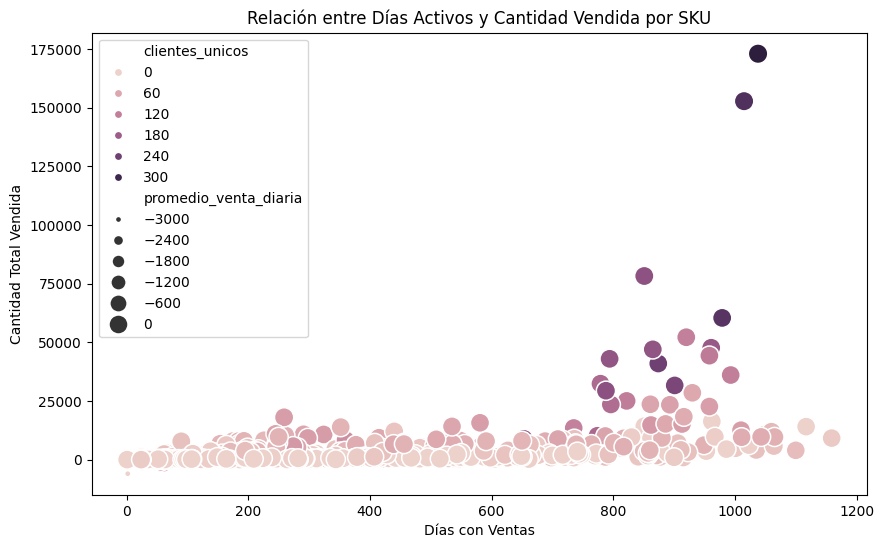

In [13]:
#Visualizacion de densidad entre dias totales y dias activos 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(data=sku_ventas, x='dias_con_ventas', y='cantidad', hue='clientes_unicos', size='promedio_venta_diaria', sizes=(20, 200))
plt.title('Relación entre Días Activos y Cantidad Vendida por SKU')
plt.xlabel('Días con Ventas')
plt.ylabel('Cantidad Total Vendida')
plt.show()


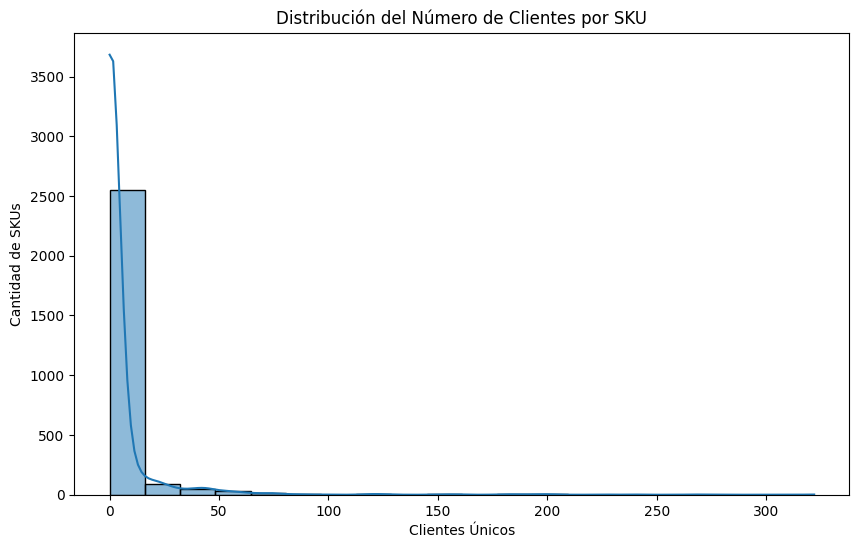

In [14]:
#Distribucion de la cantidad de clientes por SKU
plt.figure(figsize=(10,6))
sns.histplot(data=sku_ventas, x='clientes_unicos', bins=20, kde=True)
plt.title('Distribución del Número de Clientes por SKU')
plt.xlabel('Clientes Únicos')
plt.ylabel('Cantidad de SKUs')
plt.show()


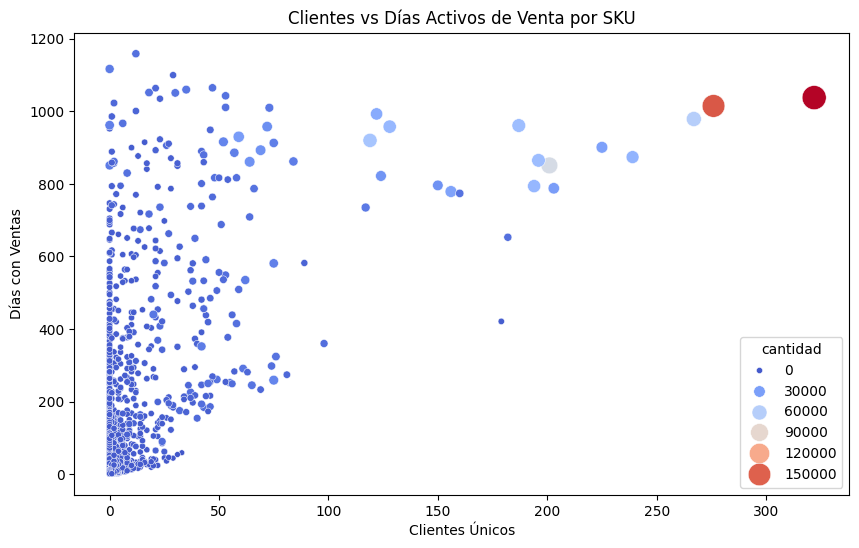

In [16]:
#Clientes unicos vs dias con ventas
plt.figure(figsize=(10,6))
sns.scatterplot(data=sku_ventas, x='clientes_unicos', y='dias_con_ventas', size='cantidad', hue='cantidad', palette='coolwarm', sizes=(10, 300))
plt.title('Clientes vs Días Activos de Venta por SKU')
plt.xlabel('Clientes Únicos')
plt.ylabel('Días con Ventas')
plt.show()



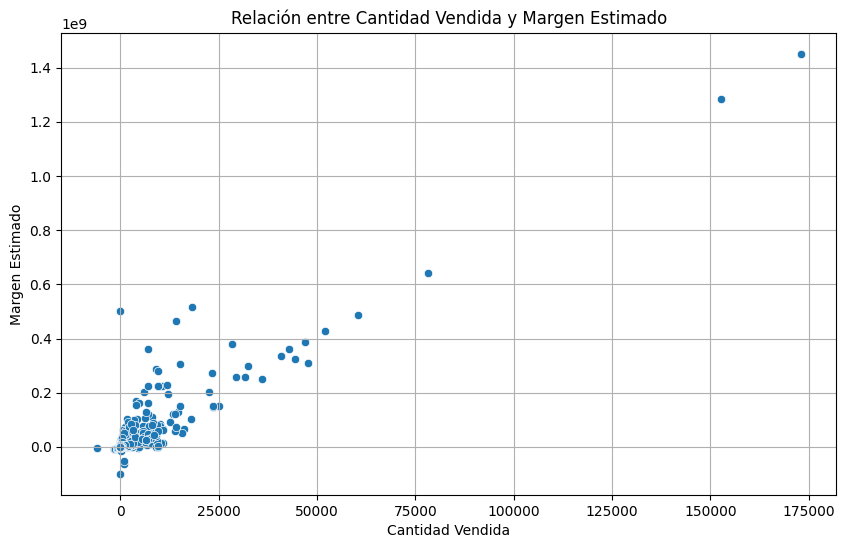

In [23]:
#Margen estimado vs cantidad vendida
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sku_ventas, x='cantidad', y='margen_estimado')
plt.title('Relación entre Cantidad Vendida y Margen Estimado')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Margen Estimado')
plt.grid(True)
plt.show()



In [24]:
#Top 20 productos que presentan una menor rotacion
sku_ventas.sort_values(by='dias_con_ventas', ascending=True).head(20)


,cod_articulo_servicio,nombre_articulo_servicio,cantidad,subtotal,costo,margen_estimado,dias_con_ventas,clientes_unicos,promedio_venta_diaria
2090,122899,ALM. YP. VENTISQUERO RVA SAUVIGNON BLANC 750,1.000,69444.44,31028.00,38416.44,1,0,1.000
442,100384,DESAYUNO LIGHT X UN,4.000,82018.09,16148.00,65870.09,1,0,4.000
433,100349,CAJA ANCHETA NAVIDAD GRANDE,1.000,23940.00,35000.00,-11060.00,1,1,1.000
2222,123036,ALM. GWS. DON MELCHOR 2019 750 ML,1.000,787037.04,366432.00,420605.04,1,0,1.000
431,100343,ROCINANTE CURADO GRANDE,0.168,17407.06,0.00,17407.06,1,0,0.168
2233,123049,YP. CASAS DEL BOSQUE GRAN RVA PINOT NOIR,1.000,146666.67,86474.00,60192.67,1,0,1.000
2273,123091,ALM. VC. QUINTA S. SEBASTIAO RESERVA TINTO 750,1.000,181481.48,70000.00,111481.48,1,0,1.000
2281,123102,ALM. GWS. CHAMPAGNE M&C BRUT IMPERIAL GIF BOX 750,1.000,421296.30,303500.00,117796.30,1,0,1.000
2297,123119,ALM. ROLLOS DE CARNE ENVUELTOS EN BERENJENA Y ...,5.000,63888.90,21090.00,42798.90,1,0,5.000
395,100219,D. MORTADELA NATURALX 2.5 X KL,-2.450,-139481.00,-109419.62,-30061.38,1,1,-2.450


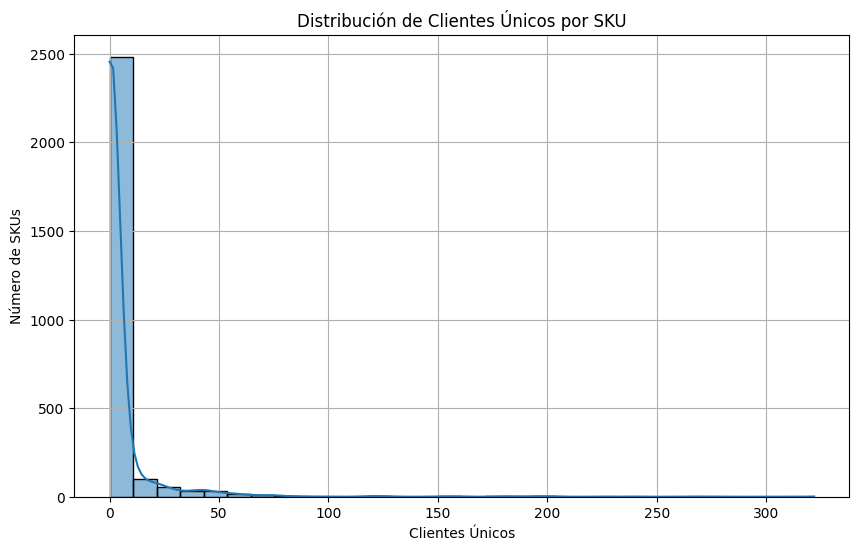

In [25]:
#Mapa de calor que muestra el SKU y el numero de clientes unicos 
plt.figure(figsize=(10, 6))
sns.histplot(sku_ventas['clientes_unicos'], bins=30, kde=True)
plt.title('Distribución de Clientes Únicos por SKU')
plt.xlabel('Clientes Únicos')
plt.ylabel('Número de SKUs')
plt.grid(True)
plt.show()


In [26]:
#Agrupacion por cliente y SKU para obtener frecuencia y cantidades 
cliente_sku_stats = ventas_items.groupby(['cod_cliente', 'cod_articulo_servicio']).agg({
    'cantidad': 'sum',
    'documento': 'count',  # puedes usar fecha si hay más granularidad
    'defecha': lambda x: x.nunique(),  # número de días distintos con ventas
}).reset_index()

# Calcular promedio mensual
cliente_sku_stats['prom_mensual'] = cliente_sku_stats['cantidad'] / cliente_sku_stats['defecha']

# Join con nombre producto
cliente_sku_stats = cliente_sku_stats.merge(
    articulos[['codigo', 'nombre']],
    left_on='cod_articulo_servicio', right_on='codigo', how='left'
)


In [27]:
#Unir nombre de cliente
cliente_sku_stats = cliente_sku_stats.merge(
    clientes[['codigo', 'razon social']],
    left_on='cod_cliente', right_on='codigo', how='left',
    suffixes=('', '_cliente')
)


In [28]:
#Agregar la logica del umbral de sobrestock
# Simple: un 50% por encima del promedio mensual
cliente_sku_stats['umbral_sobrestock'] = cliente_sku_stats['prom_mensual'] * 1.5


In [29]:
#Mostrar vista previa representative para obtener frecuencias y cantidades por clientes
import pandas as pd
import plotly.express as px

# Mostrar una muestra representativa
cliente_sku_stats.sort_values(by='prom_mensual', ascending=False).head(10)


,cod_cliente,cod_articulo_servicio,cantidad,documento,defecha,prom_mensual,codigo,nombre,codigo_cliente,razon social,umbral_sobrestock
11,CL 10003,101039,75749.0,339,53,1429.226415,101039,MERMEL 4 FRUTAS ST DALF X 284 GR,CL 10003,ALMACENES EXITO S A,2143.839623
14,CL 10003,101055,68540.0,356,68,1007.941176,101055,MERMEL FRESA ST DALF X 284 GR,CL 10003,ALMACENES EXITO S A,1511.911765
2337,CL 20008,100722,1334.0,2,2,667.000000,100722,CAJA REGALO CAVA DE QUESOS,CL 20008,COLTANQUES S.A.S.,1000.500000
2367,CL 20008,121868,660.0,1,1,660.000000,121868,CHORIZO EXTRA LONCHAS ARROYO X 70 G,CL 20008,COLTANQUES S.A.S.,990.000000
2366,CL 20008,121867,660.0,1,1,660.000000,121867,JAMON SERRANO ARROYO X 50 G,CL 20008,COLTANQUES S.A.S.,990.000000
2381,CL 20008,123241,600.0,1,1,600.000000,123241,EMBORG. CAMEMBERT X 125 G,CL 20008,COLTANQUES S.A.S.,900.000000
2342,CL 20008,101096,1040.0,2,2,520.000000,101096,MERMEL MINI CAJA X 4 UNID X 28 GR,CL 20008,COLTANQUES S.A.S.,780.000000
17,CL 10003,101062,22781.0,300,51,446.686275,101062,MERMEL DURAZNO ST DALF X 284 GR,CL 10003,ALMACENES EXITO S A,670.029412
2376,CL 20008,122460,400.0,1,1,400.000000,122460,LF. SALAMI FINAS HIERBAS X 100,CL 20008,COLTANQUES S.A.S.,600.000000
2378,CL 20008,122646,400.0,1,1,400.000000,122646,CDV. CARPINETO CHIANTI CASTALDO 750,CL 20008,COLTANQUES S.A.S.,600.000000


In [33]:
# 📋 Reglas de negocio sugeridas para identificar el sobrestock por tipo de cliente y SKU

# 🧮 Agrupar por cliente y SKU para obtener frecuencia y cantidades
cliente_sku_stats = ventas_items.groupby(['cod_cliente', 'cod_articulo_servicio']).agg({
    'cantidad': 'sum',
    'documento': 'count',
    'defecha': lambda x: x.nunique()  # número de fechas distintas con ventas
}).reset_index()

# 📅 Calcular promedio mensual (cantidad promedio por mes)
cliente_sku_stats['prom_mensual'] = cliente_sku_stats['cantidad'] / cliente_sku_stats['defecha']

# 📈 Agregar lógica de sobrestock: 50% por encima del promedio mensual
cliente_sku_stats['umbral_sobrestock'] = cliente_sku_stats['prom_mensual'] * 1.5

# 🏷️ Agregar nombre del producto
cliente_sku_stats = cliente_sku_stats.merge(
    articulos[['codigo', 'nombre']],
    left_on='cod_articulo_servicio',
    right_on='codigo',
    how='left'
)

# 🧾 Agregar razón social del cliente
cliente_sku_stats = cliente_sku_stats.merge(
    clientes[['codigo', 'razon social']],
    left_on='cod_cliente',
    right_on='codigo',
    how='left',
    suffixes=('', '_cliente')
)

# ✅ Seleccionar columnas finales limpias para presentación
tabla_final = cliente_sku_stats[[
    'cod_cliente',
    'razon social',
    'cod_articulo_servicio',
    'nombre',
    'cantidad',
    'defecha',
    'prom_mensual',
    'umbral_sobrestock'
]].sort_values(by='prom_mensual', ascending=False).reset_index(drop=True)

# 👀 Mostrar tabla final
tabla_final.head(300)


,cod_cliente,razon social,cod_articulo_servicio,nombre,cantidad,defecha,prom_mensual,umbral_sobrestock
0,CL 10003,ALMACENES EXITO S A,101039,MERMEL 4 FRUTAS ST DALF X 284 GR,75749.0,53,1429.226415,2143.839623
1,CL 10003,ALMACENES EXITO S A,101055,MERMEL FRESA ST DALF X 284 GR,68540.0,68,1007.941176,1511.911765
2,CL 20008,COLTANQUES S.A.S.,100722,CAJA REGALO CAVA DE QUESOS,1334.0,2,667.000000,1000.500000
3,CL 20008,COLTANQUES S.A.S.,121868,CHORIZO EXTRA LONCHAS ARROYO X 70 G,660.0,1,660.000000,990.000000
4,CL 20008,COLTANQUES S.A.S.,121867,JAMON SERRANO ARROYO X 50 G,660.0,1,660.000000,990.000000
...,...,...,...,...,...,...,...,...
295,CL 100000000118,GOMEZ PABON JAVIER MANYIBER,150174,ILE DE FRANCE BRIE X 125 GR,330.0,7,47.142857,70.714286
296,CL 100000000398,CENCOSUD COLOMBIA S.A.,123228,EMBORG. SWISS RACLETTE TAJADA X 300G,1836.0,39,47.076923,70.615385
297,CL 100000001314,DELGADO PRADO RUTH ESTELA,122377,PATE IBERICO CRISTAL X 100 G POLGRI,141.0,3,47.000000,70.500000
298,CL 10378,SUPERTIENDAS Y DROGUERIAS OLIMPICA S.A.,101055,MERMEL FRESA ST DALF X 284 GR,5296.0,113,46.867257,70.300885


In [43]:
import pandas as pd

# 🧮 Agrupar por cliente y SKU
cliente_sku_stats = ventas_items.groupby(['cod_cliente', 'cod_articulo_servicio']).agg(
    cantidad=('cantidad', 'sum'),
    defecha=('fecha', 'nunique'),
    ultima_venta=('cantidad', 'last')  # Última cantidad registrada para esa combinación
).reset_index()

# 📊 Calcular promedio mensual de unidades
cliente_sku_stats['prom_mensual'] = cliente_sku_stats['cantidad'] / cliente_sku_stats['defecha']

# 📈 Umbral tentativo de sobrestock: 50% por encima del promedio mensual
cliente_sku_stats['umbral_sobrestock'] = cliente_sku_stats['prom_mensual'] * 1.5

# 🧩 Agregar nombre del producto
cliente_sku_stats = cliente_sku_stats.merge(
    articulos[['codigo', 'nombre']],
    left_on='cod_articulo_servicio', right_on='codigo', how='left'
)

# 🧍‍♂️ Agregar nombre del cliente
cliente_sku_stats = cliente_sku_stats.merge(
    clientes[['codigo', 'razon social']],
    left_on='cod_cliente', right_on='codigo', how='left',
    suffixes=('', '_cliente')
)

# 🏷️ Renombrar columnas para formato final
cliente_sku_stats = cliente_sku_stats.rename(columns={
    'cod_articulo_servicio': 'SKU',
    'nombre': 'Nombre Producto',
    'razon social': 'Cliente',
    'prom_mensual': 'Prom. Unidades por Mes',
    'defecha': 'Días con Venta',
    'ultima_venta': 'Unidades en Última Compra',
    'umbral_sobrestock': 'Umbral Sobrestock Tentativo'
})

# 🧼 Asegurar que SKU esté como texto (para ordenar bien)
cliente_sku_stats['SKU'] = cliente_sku_stats['SKU'].astype(str)

# 🧽 Limpiar valores negativos en columnas clave
cols_a_limpiar = [
    'Prom. Unidades por Mes',
    'Unidades en Última Compra',
    'Umbral Sobrestock Tentativo'
]
for col in cols_a_limpiar:
    cliente_sku_stats[col] = cliente_sku_stats[col].apply(lambda x: max(x, 0))

# ✅ Seleccionar y reordenar columnas
columnas_finales = [
    'SKU',
    'Nombre Producto',
    'Cliente',
    'Prom. Unidades por Mes',
    'Días con Venta',
    'Unidades en Última Compra',
    'Umbral Sobrestock Tentativo'
]

tabla_final = cliente_sku_stats[columnas_finales].sort_values(by='Prom. Unidades por Mes', ascending=False)

# 📁 Exportar a Excel
tabla_final.to_excel("umbral_sobrestock_por_cliente.xlsx", index=False)

# 👁️ Vista previa
tabla_final.head(10)


,SKU,Nombre Producto,Cliente,Prom. Unidades por Mes,Días con Venta,Unidades en Última Compra,Umbral Sobrestock Tentativo
11,101039,MERMEL 4 FRUTAS ST DALF X 284 GR,ALMACENES EXITO S A,1429.226415,53,0.0,2143.839623
14,101055,MERMEL FRESA ST DALF X 284 GR,ALMACENES EXITO S A,1007.941176,68,0.0,1511.911765
2337,100722,CAJA REGALO CAVA DE QUESOS,COLTANQUES S.A.S.,667.000000,2,694.0,1000.500000
2367,121868,CHORIZO EXTRA LONCHAS ARROYO X 70 G,COLTANQUES S.A.S.,660.000000,1,660.0,990.000000
2366,121867,JAMON SERRANO ARROYO X 50 G,COLTANQUES S.A.S.,660.000000,1,660.0,990.000000
2381,123241,EMBORG. CAMEMBERT X 125 G,COLTANQUES S.A.S.,600.000000,1,600.0,900.000000
2342,101096,MERMEL MINI CAJA X 4 UNID X 28 GR,COLTANQUES S.A.S.,520.000000,2,400.0,780.000000
17,101062,MERMEL DURAZNO ST DALF X 284 GR,ALMACENES EXITO S A,446.686275,51,0.0,670.029412
2376,122460,LF. SALAMI FINAS HIERBAS X 100,COLTANQUES S.A.S.,400.000000,1,400.0,600.000000
2378,122646,CDV. CARPINETO CHIANTI CASTALDO 750,COLTANQUES S.A.S.,400.000000,1,400.0,600.000000


In [44]:
# Exportar el DataFrame a un archivo Excel
tabla_final.to_excel("umbral_sobrestock_por_cliente.xlsx", index=False)
